In [146]:
import numpy as np
from bs4 import BeautifulSoup
import tensorflow as tf
import urllib
import pickle
import collections
import random
import argparse
import os, sys
from six.moves import xrange
from tensorflow.contrib.tensorboard.plugins import projector
current_path = os.path.dirname(os.path.realpath(sys.argv[0]))

In [3]:
class MP:
    def __init__(self, name, twitter_handle, party):
        self.name = name;
        self.twitter_handle = twitter_handle
        self.party = party
        self.tweets = []
    def addTweet(self, tweet):
        self.tweets.append(tweet)
    def __str__(self):
        return 'Name: %s, TW: %s, Party: %s' % (self.name, self.twitter_handle, self.party)
        
list_of_mps = []

url = 'https://www.mpsontwitter.co.uk/list'
with urllib.request.urlopen(url) as doc:
    soup = BeautifulSoup(doc, 'html.parser')
    rows = soup.find_all('tr')
    for i in range(2,len(rows)):
        party = rows[i].find('td')['class'][0]
        twitter_handle = rows[i].find('a').getText()
        name = rows[i].find_all('td')[2].getText()
        list_of_mps.append(MP(name, twitter_handle, party))
        

### Tweepy API
Using the [Tweepy API](http://tweepy.readthedocs.io/en/v3.5.0/) to extract the tweets from each of the MPs - I have already used pickle to export these into a txt file so I no longer need to run the code. 

In [241]:
consumer_key = 'your_key'
consumer_secret = 'you_secret'
access_token = 'your_token'
access_secret = 'your_access_secret'


import tweepy as tw
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tw.API(auth)

for mp in list_of_mps:
    try:
        tweets = api.user_timeline(mp.twitter_handle, count=50)
        for tweet in tweets:
            mp.addTweet(tweet.text)
    except tw.TweepError:
        print('Protected Tweets :(')
        
with open('test.txt', 'wb') as testFile:
    pickle.dump(list_of_mps, testFile)

Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(
Protected Tweets :(


KeyboardInterrupt: 

### Tokenization
Using the nltk package we can tokenize the tweets into each twitter token - this can be useful because it can deal with links, @twitter_users etc. 

In [142]:
from nltk.tokenize import TweetTokenizer
import math
tknzr = TweetTokenizer()

with open('data.txt', 'rb') as testFile:
    mps = pickle.load(testFile)
    
parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()

In [108]:
vocabulary = []
vocabulary_size = 50000

for mp in mps:
    if len(mp.tweets) > 0:
        for tweet in mp.tweets:
            tokens = tknzr.tokenize(tweet)
            for token in tokens:
                vocabulary.append(token)
            
def build_dataset(words, n_words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)
    unk_count = 0
    data = []
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary
        
    
data, count, dictionary, reversed_dictionary = build_dataset(vocabulary, vocabulary_size)

In [126]:
data_index = 0

def batch_generator(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels


batch, labels = batch_generator(batch_size=20, num_skips=4, skip_window=4)

for i in range(20):
    print(batch[i], reversed_dictionary[batch[i]], '->', labels[i, 0],
        reversed_dictionary[labels[i, 0]])        

3 to -> 206 @Conservatives
3 to -> 1754 committed
3 to -> 10 a
3 to -> 9 and
10 a -> 206 @Conservatives
10 a -> 30 are
10 a -> 1754 committed
10 a -> 914 #NHS
3722 comprehensive -> 9 and
3722 comprehensive -> 914 #NHS
3722 comprehensive -> 1754 committed
3722 comprehensive -> 5 .
9 and -> 2432 universal
9 and -> 3 to
9 and -> 3722 comprehensive
9 and -> 1754 committed
2432 universal -> 3 to
2432 universal -> 5 .
2432 universal -> 914 #NHS
2432 universal -> 3722 comprehensive


## Tensorflow 
Now it is time to start using tensorflow and the word2vec model - they have a great [tutorial](https://www.tensorflow.org/tutorials/representation/word2vec) on their website, but let's go over a few basic concepts the first being 'What is an embedding?'. 

An embedding is a way to take our input data (the word strings) and convert them to numbers. Neural networks generally work in numbers in order to do all of the calculations like matrix multiplication, gradient-descent etc. Tensorflow, lucky for us, has a built-in function that can create for us an embedding of a desired shape. For us we want a matrix of vocabulary_size (all the unique words in our data) and we can give an arbitary embedding_size. 

We will use the Noise Contrastive Estimation loss as our 'how well did we do?' function - this essentially draws on randomly selected other target words and compares them to our guess. When our guess has a high probability and the random selection of 'noisy' words has a low probability, we are doing well. This reduces the computation from testing all V words in our vocabulary to a pre-selected K noisy words. 

In [130]:
#Constant Variables
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
num_sampled = 64

valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [133]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        
    with tf.device('/cpu:0'):
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)
            
        with tf.name_scope('weights'):
            nce_weights = tf.Variable(
                tf.truncated_normal(
                    [vocabulary_size, embedding_size],
                    stddev=1.0 / math.sqrt(embedding_size)))
        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
            
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))
            
    tf.summary.scalar('loss', loss)
        
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
            
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings/norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
        
    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [151]:
num_steps = 100001
with tf.Session(graph=graph) as session:
    writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)
    init.run()
    print('INIT')
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = batch_generator(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        run_metadata = tf.RunMetadata()
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict=feed_dict,
            run_metadata=run_metadata)
        average_loss += loss_val
        
        writer.add_summary(summary, step)
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)
            
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
    final_embeddings = normalized_embeddings.eval()

    # Write corresponding labels for the embeddings.
    with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
        for i in xrange(vocabulary_size):
            f.write(reversed_dictionary[i] + '\n')

    # Save the model for checkpoints.
    saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

    # Create a configuration for visualizing embeddings with the labels in TensorBoard.
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)

writer.close()
        
        

INIT
Average loss at step  0 :  288.281890869
Average loss at step  2000 :  113.414988645
Average loss at step  4000 :  58.8903029296
Average loss at step  6000 :  40.5500789804
Average loss at step  8000 :  29.8492837541
Average loss at step  10000 :  19.5826407399
Average loss at step  12000 :  11.1842085317
Average loss at step  14000 :  11.8695571923
Average loss at step  16000 :  10.5841751185
Average loss at step  18000 :  9.11364859521
Average loss at step  20000 :  6.91864816713
Average loss at step  22000 :  5.34972392172
Average loss at step  24000 :  5.82125033712
Average loss at step  26000 :  5.39569867849
Average loss at step  28000 :  5.21527495539
Average loss at step  30000 :  4.60336926502
Average loss at step  32000 :  4.50248982733
Average loss at step  34000 :  4.68046674848
Average loss at step  36000 :  4.5200640178
Average loss at step  38000 :  4.41964373052
Average loss at step  40000 :  4.14737298566
Average loss at step  42000 :  4.26337160122
Average loss a

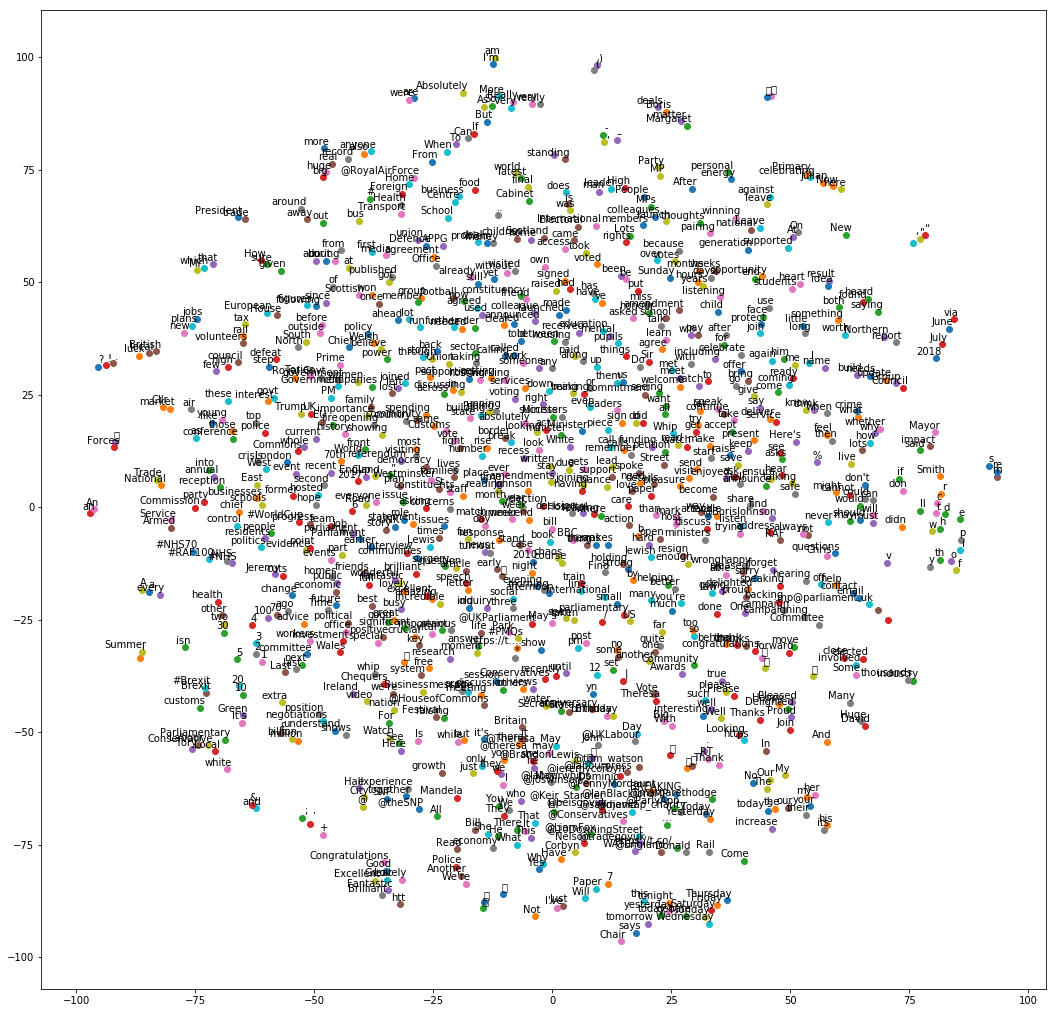

In [240]:
from tempfile import gettempdir
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)


try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(
        perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 1000
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reversed_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'other.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

In [236]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
def top_n_similar_words(word, n):
    index = dictionary[word]
    vector_representation = low_dim_embs[index]
    csim = cosine_similarity([vector_representation], low_dim_embs)
    esim = euclidean_distances([vector_representation], low_dim_embs)
    cindices = np.argsort(csim)
    eindices = np.argsort(esim)
    top_n = []
    for id1, id2 in zip(cindices[0][-n:], eindices[0][:n]) :
        top_n.append((reversed_dictionary[id1], reversed_dictionary[id2]))
    return top_n

top_n_similar_words('Jeremy', 20)

[('questions', 'Jeremy'),
 ('NHS', 'cuts'),
 ('concerns', 'Chris'),
 ('history', '..'),
 ('#NHS70', 'questions'),
 ('families', 'name'),
 ('issue', '30'),
 ('Chris', 'staff'),
 ('#NHS', 'two'),
 ('hosted', 'families'),
 ('#WorldCup', 'lives'),
 ('staff', 'other'),
 ('/', 'constituents'),
 ('cuts', 'letter'),
 ('progress', 'health'),
 ('St', 'Commission'),
 ('hope', 'speech'),
 ('constituents', '£'),
 ('..', 'St'),
 ('Jeremy', 'concerns')]

In [238]:
#Classification Algorithm
print(mps[0].tweets)

['.@Conservatives are committed to a comprehensive and universal #NHS. 70 years young, I hope it will outlive us all… https://t.co/kKByBm1zwX', 'Thanks to ITV for a great party this evening. Good to be surrounded by intellectuals. Watch out for Anne in Windsor… https://t.co/CbovInslxH', 'Good to chair meeting of the Parliamentary Office of Science &amp; Tech, with our impressive new Director Grant Cawthor… https://t.co/j2HtXQDwUH', "One day after Heathrow hoodwinked the Government to support 3rd runway and stop anybody else building one...it's le… https://t.co/Zu0OIwuqL1", 'A 3rd Runway will mean higher landing charges and less competition. That might be in Heathrow’s interests, but it i… https://t.co/Vrn4AytFbm', "My speech objecting to Heathrow's 3rd runway, which is not in our national economic interest (part 2) @RAAN_BERKS… https://t.co/Fq3699wkXU", "My speech objecting to Heathrow's 3rd runway, which is not in our national economic interest (part 1)… https://t.co/VYNNISBqh8", 'Ple